In [1]:
import plotly
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import os

In [2]:
if os.name == 'nt':
    plotly.io.orca.config.executable = 'C:/Users/kharianne/AppData/Local/Programs/orca/orca.exe'
    conf_gl = pd.read_csv("../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
    deaths_gl = pd.read_csv("../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
else:    
    conf_gl = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
    deaths_gl = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

In [3]:
base_country = ("Italy", 60480000)
countries_to_watch = {
    "Czechia": base_country[1]/10650000,
    "Sweden": base_country[1]/10230000,
    "US":base_country[1]/328239523
}

In [4]:
def clear_transpose(df, state):
    num = df.index[0]
    df = df.drop(["Province/State", "Country/Region", "Lat", "Long"],1)
    df = df.transpose()
    df = df.rename(columns={num: state})
    df = df[df[state] > 0]
    mapper = {}
    for i, date in enumerate(df.index.values.tolist()):
        mapper.update({date:i})
    df = df.rename(mapper, axis='index')
    return df

In [5]:
def slice_by_country(base_df, country):
    df = base_df[base_df["Country/Region"] == country]
    if not df.empty:
        df = clear_transpose(df, country)
        return df
    else:
        raise ValueError(f"{country} was not found in dataframe")

In [6]:
def concat_slices(slices):
    #keys = [slice.columns[0] for slice in slices]
    summary = pd.concat(slices, axis=1)
    return summary

In [7]:
def apply_ratio(df):
    for country in df.columns:
        if country == base_country[0]:
            continue
        df[country] = df[country].apply(lambda x: x * countries_to_watch[country])   
    return df

In [8]:
def plot_plotly(df, info_dict, type='png'):
    fig = go.Figure()
    
    for column in df.columns:
        fig.add_trace(go.Scatter(y=df[column],
                    mode='lines',
                   name=column))
    fig.update_layout(
        title= {
            'text': info_dict['title_text'],
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title=info_dict['xaxis_title'],
        yaxis_title=info_dict['yaxis_title'])
    fig.show(type)

In [9]:
def get_pct_change(df):
    pct_change_df = pd.DataFrame()
    for column in df.columns:
        pct_change_df[column] = df[column].pct_change(limit=1)
    return pct_change_df

In [10]:
def get_last_x_days(df, x):
    slices = []
    for column in df.columns:
        new = df[column].dropna(axis=0)
        slices.append(new[new.index.size - x - 1 : new.index.size + 1].reset_index(drop=True))
    return concat_slices(slices)

In [11]:
country_slices_conf = [slice_by_country(conf_gl, base_country[0])]
for country in countries_to_watch:
    try:
        country_slices_conf.append(slice_by_country(conf_gl, country))
    except ValueError as e:
        print(e)
        continue

In [12]:
country_slices_deaths = [slice_by_country(deaths_gl, base_country[0])]
for country in countries_to_watch:
    try:
        country_slices_deaths.append(slice_by_country(deaths_gl, country))
    except ValueError as e:
        print(e)
        continue

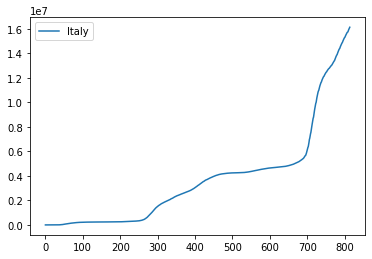

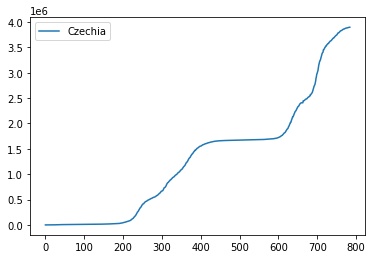

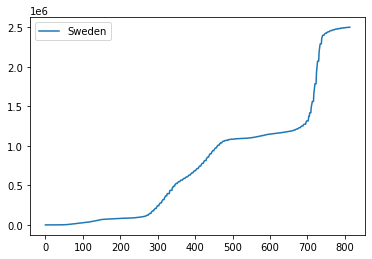

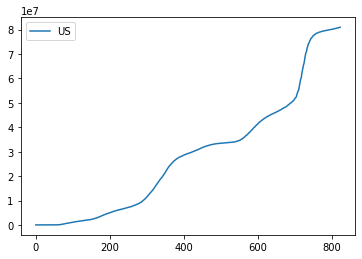

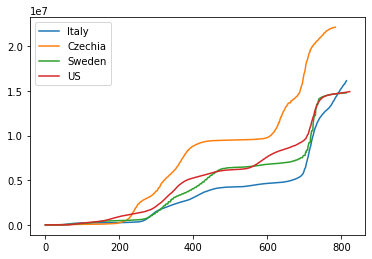

In [13]:
for slice in country_slices_conf:
    slice.plot.line()
summary = concat_slices(country_slices_conf)
summary = apply_ratio(summary)
summary.plot.line()

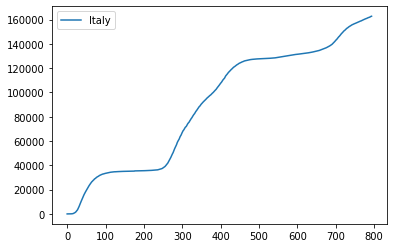

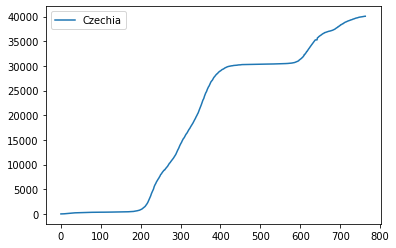

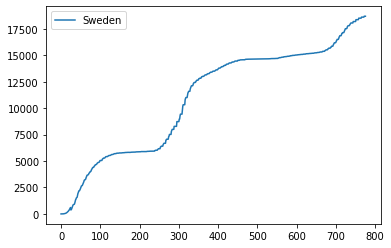

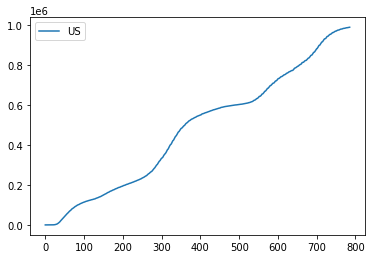

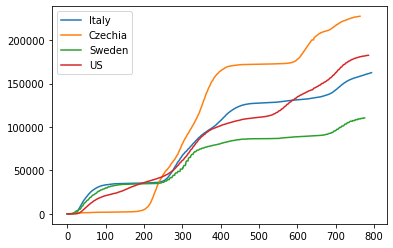

In [14]:
for slice in country_slices_deaths:
    slice.plot.line()
summary_deaths = concat_slices(country_slices_deaths)
summary_deaths = apply_ratio(summary_deaths)
summary_deaths.plot.line()

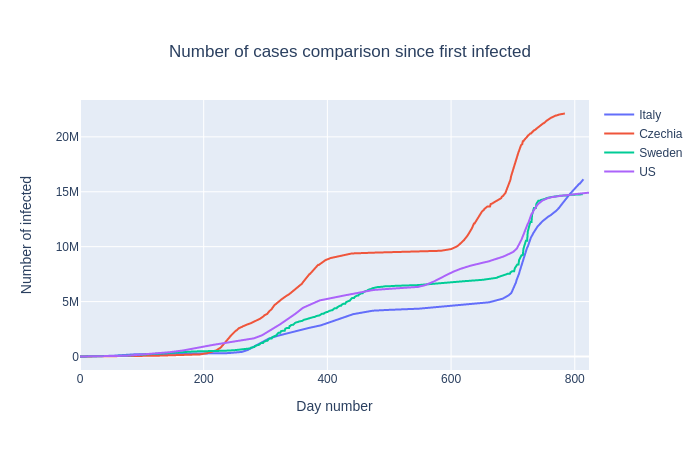

In [15]:
plot_plotly(summary, {
    'title_text': 'Number of cases comparison since first infected',
    'xaxis_title': 'Day number',
    'yaxis_title': 'Number of infected'  
})

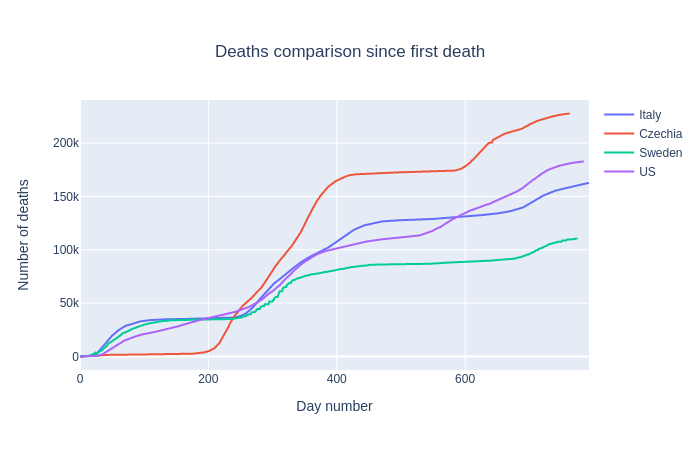

In [16]:
plot_plotly(summary_deaths, {
    'title_text': 'Deaths comparison since first death',
    'xaxis_title': 'Day number',
    'yaxis_title': 'Number of deaths'  
})

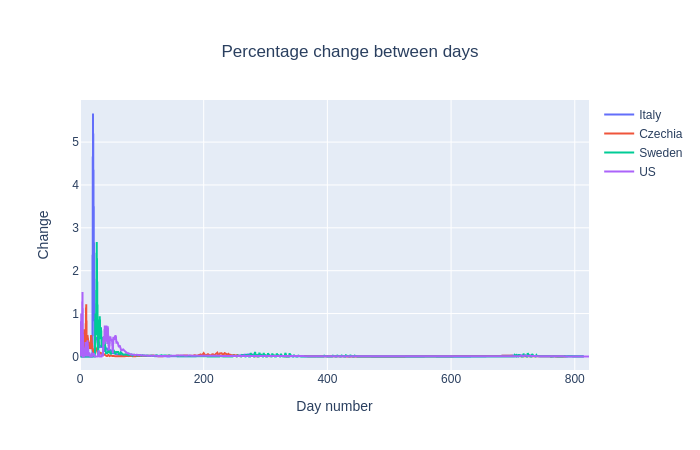

In [17]:
plot_plotly(get_pct_change(summary), {
    'title_text': 'Percentage change between days',
    'xaxis_title': 'Day number',
    'yaxis_title': 'Change'  
}, type='png')

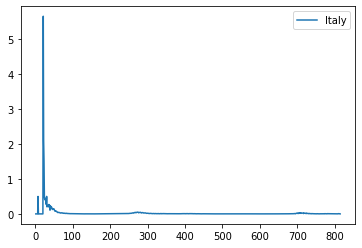

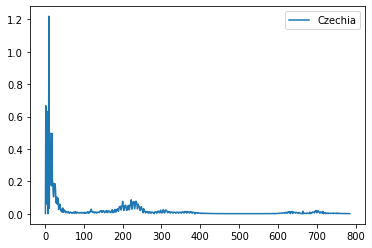

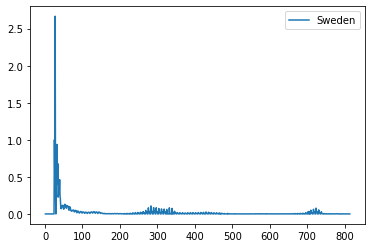

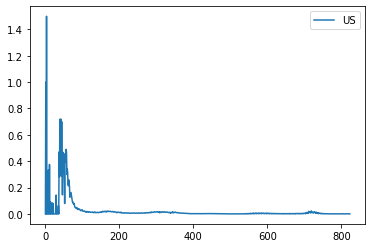

In [18]:
pct_change = get_pct_change(summary)
for column in pct_change.columns:
    pct_change.plot(y=column)

In [19]:
last_x_days = get_last_x_days(pct_change, 20)

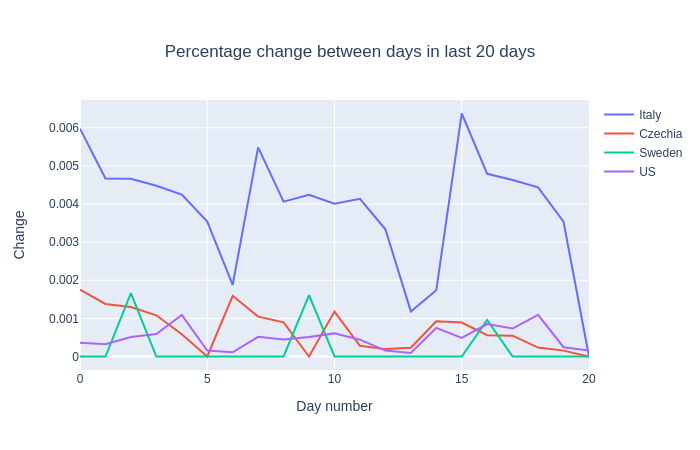

In [20]:
plot_plotly(last_x_days, {
    'title_text': 'Percentage change between days in last 20 days',
    'xaxis_title': 'Day number',
    'yaxis_title': 'Change'  
}, type='png')